<a href="https://colab.research.google.com/github/Himasishghosal/Control-Theory_And_ANN/blob/main/2_MLP_CONTROL.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#**`"Neural Network-Based Control for Satellite System Dynamics"`**

>#                                           `Presented By Himasish Ghosal`

>#                                            `Guided By Prof. Raju.k.George`

#**Objective:**
**To design a machine learning-based control system using a Multi-Layer Perceptron (MLP) to generate optimal control inputs for a satellite system modeled by a linear time-invariant state-space representation.**

#**Key Concepts Applied:**

1. **Time-invariant linear systems**

2. **Satellite orbit dynamics**

3. **Control theory fundamentals**

4. **Neural networks (MLP in TensorFlow)**

5. **Supervised learning with generated dataset**

#**1.1. BASIC LIBRARIES AND  GIVEN SATELLITE'S DYNAMICS**  

In [ ]:
pip install tensorflow

In [2]:
import numpy as np
from scipy.linalg import expm
import matplotlib.pyplot as plt

# Parameter
omega = 1

# System matrices(Satellite system)
A = np.array([[0, 1, 0, 0],
              [3*omega**2, 0, 0, 2*omega],
              [0, 0, 0, 1],
              [0, -2*omega, 0, 0]])

B = np.array([[0, 0],
              [1, 0],
              [0, 0],
              [0, 1]])

n = A.shape[0]        # state dimension
m = B.shape[1]
T = 1.0               # final time
N = 100               # number of time points
time_points = np.linspace(0, T, N)


#**1.2. DATASET GENERATION FOR TRAINING THE NEURAL NETWORK**




In [3]:
from scipy.integrate import quad_vec
from scipy.linalg import expm

def compute_grammian(A, B, T):
    def integrand(t):
        e_At = expm(A * (T - t))
        return e_At @ B @ B.T @ e_At.T  # returns 2D (n x n) NumPy array

    W, _ = quad_vec(integrand, 0, T)
    return W

# Generate u(t) numerically
def compute_control(A, B, x0, x1, T, time_points):
    W = compute_grammian(A, B, T)
    W_inv = np.linalg.inv(W)
    expAT = expm(A * T)
    diff = x1 - expAT @ x0

    u_vals = []
    for t in time_points:
        e_AtT = expm(A.T * (T - t))
        u_t = B.T @ e_AtT @ W_inv @ diff
        u_vals.append(u_t)
    return np.array(u_vals).T  # shape: (m, N)

# Generate dataset
np.random.seed(42)       # seed for reproducibility
def sample_data_numeric(num_samples=2000):
    X, Y = [], []
    for _ in range(num_samples):
        x0 = np.random.uniform(0, 3, n)
        x1 = np.random.uniform(0, 3, n)
        u_vals = compute_control(A, B, x0, x1, T, time_points)
        X.append(np.concatenate([x0, x1]))   # shape of each input data: (2*n,)
        Y.append(u_vals.flatten())  # shape of each output data: (m * N,)
    return np.array(X), np.array(Y)

# Generate and save
X_data, Y_data = sample_data_numeric(num_samples=2000)
np.savez("controller_dataset.npz", X=X_data, Y=Y_data, time=time_points)
print("Numeric dataset saved as controller_dataset.npz")


Numeric dataset saved as controller_dataset.npz


#**1.3.MLP MODEL TRAINING**

In [4]:
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras import regularizers

# Load dataset
data = np.load('/content/controller_dataset.npz')
X = data['X']  # shape: (2000, 2*n)
Y = data['Y']  # shape: (2000, m*N)
time_points = data['time']  # shape: (100,)

# Split into training and validation sets
split = int(0.8 * len(X))
X_train, X_val = X[:split], X[split:]
Y_train, Y_val = Y[:split], Y[split:]

# To Define the Sequential model with L2 regularization
model = models.Sequential([
    layers.Dense(32, activation='relu', input_shape=(8,),
                 kernel_regularizer=regularizers.l2(0.0001)), # Added L2 regularization
    layers.Dense(128, activation='relu',
                 kernel_regularizer=regularizers.l2(0.0001)), # Added L2 regularization
    layers.Dense(256, activation='relu',
                 kernel_regularizer=regularizers.l2(0.0001)), # Added L2 regularization
    layers.Dense(200) # 2 control inputs × 100 time steps and no Activation func as its a regression task
])
# Compile
model.compile(optimizer='adam', loss='mse',metrics=['accuracy'])

# Train
history = model.fit(X_train, Y_train, epochs=50, batch_size=64,
                    validation_data=(X_val, Y_val), verbose=1)


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 4s 19ms/step - accuracy: 0.0028 - loss: 64.0445 - val_accuracy: 0.3225 - val_loss: 35.1525
Epoch 2/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.4018 - loss: 32.2413 - val_accuracy: 0.0050 - val_loss: 26.0604
Epoch 3/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.1189 - loss: 23.3028 - val_accuracy: 0.2750 - val_loss: 15.0361
Epoch 4/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.2930 - loss: 13.1603 - val_accuracy: 0.3075 - val_loss: 4.8371
Epoch 5/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.3391 - loss: 3.5987 - val_accuracy: 0.5675 - val_loss: 1.2888
Epoch 6/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.6338 - loss: 1.1884 - val_accuracy: 0.7000 - val_loss: 0.7180
Epoch 7/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.7078 - loss: 0.6063 - val_accuracy: 0.7350 - val_loss: 0.3889
Epoch 8/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.7270 - loss: 0.3193 - val_accuracy: 0.7350 - v

In [5]:
print(model.summary())

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 32)             │           288 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 128)            │         4,224 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 256)            │        33,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 200)            │        51,400 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 266,810 (1.02 MB)

 Trainable params: 88,936 (347.41 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 177,874 (694.82 KB)

None


#**1.4 MODEL EVALUATION AND VISUALIZATION**

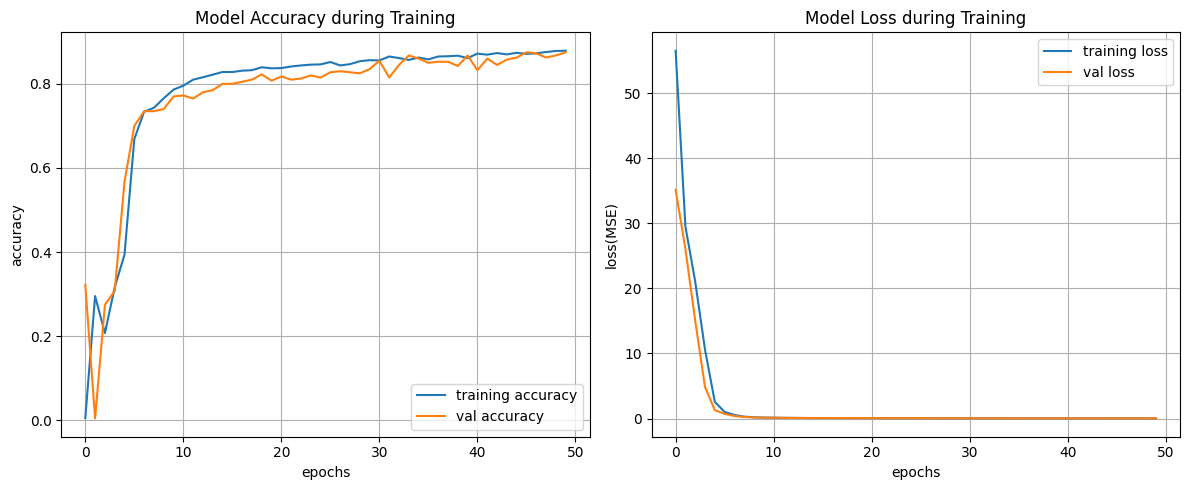

In [6]:
#plotting graphs for accuracy and loss side-by-side
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

# Plot training and validation accuracy
axes[0].plot(history.history['accuracy'], label='training accuracy')
axes[0].plot(history.history['val_accuracy'], label='val accuracy')
axes[0].set_title('Model Accuracy during Training')
axes[0].set_xlabel('epochs')
axes[0].set_ylabel('accuracy')
axes[0].legend()
axes[0].grid(True)

# Plot training and validation loss
axes[1].plot(history.history['loss'], label='training loss')
axes[1].plot(history.history['val_loss'], label='val loss')
axes[1].set_title('Model Loss during Training')
axes[1].set_xlabel('epochs')
axes[1].set_ylabel('loss(MSE)')
axes[1].legend()
axes[1].grid(True)

plt.tight_layout()
plt.show()

#**1.5. MODEL PREDICTION**

In [8]:
# Predict for new initial and final states
x0 = np.array([0.1, 0.2, 0.3, 0.4])
x1 = np.array([0, 0, 0, 0])
x_input = np.concatenate([x0, x1]).reshape(1, -1)
print(x_input)

u_pred = model.predict(x_input).reshape(2, -1)  # shape: (2, 100)
print(u_pred)


[[0.1 0.2 0.3 0.4 0.  0.  0.  0. ]]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step
[[-0.5424134  -0.5781879  -0.61544585 -0.62815    -0.61278    -0.66826296
  -0.68135583 -0.71331143 -0.6916025  -0.71343905 -0.7417874  -0.7138751
  -0.724089   -0.74940485 -0.79320127 -0.73552966 -0.76710045 -0.77438104
  -0.77730286 -0.7443522  -0.807558   -0.79221445 -0.8059815  -0.84459955
  -0.8058583  -0.8086005  -0.7640023  -0.7384167  -0.7887354  -0.74790436
  -0.73462445 -0.6885236  -0.75198907 -0.70856595 -0.6702621  -0.65775925
  -0.6455072  -0.6180109  -0.59967875 -0.6276936  -0.588914   -0.5494646
  -0.521217   -0.48575374 -0.44077834 -0.42385015 -0.39860138 -0.3770578
  -0.3830424  -0.3458869  -0.32489142 -0.25615484 -0.28816468 -0.18421772
  -0.17527184 -0.09998348 -0.09702528 -0.0653058   0.01036734  0.03646079
   0.09876285  0.11190325  0.15039255  0.26686436  0.27043447  0.3252016
   0.38452068  0.44209692  0.4543882   0.5360692   0.5679192   0.5978847
   0.71648896  0.7514711   0.8161213   0.83

#**1.6. PREDICTED CONTROL INPUTS PLOTTING**

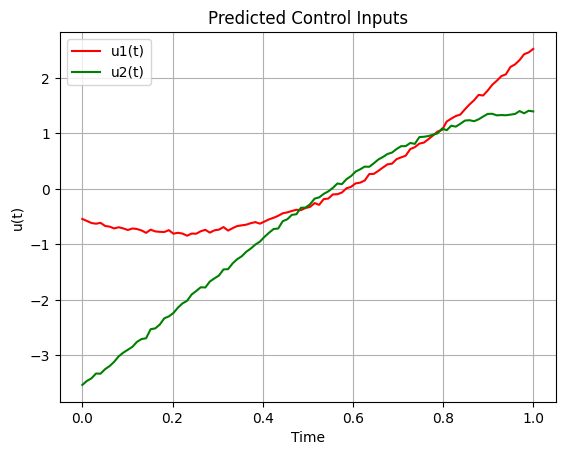

In [9]:
import matplotlib.pyplot as plt
plt.figure()
plt.plot(time_points, u_pred[0], label='u1(t)', color='r')
plt.plot(time_points, u_pred[1], label='u2(t)', color='g')
plt.title("Predicted Control Inputs")
plt.xlabel("Time")
plt.ylabel("u(t)")
plt.legend()
plt.grid(True)
plt.show()


#**1.7. SOLUTION OF THE SYSTEM WITH PREDICTED CONTROLS**

##**1.7.1.Using Simpson's rule**

The solution of the system using discrete integration of the formula is:
State at t=1.00: [-0.00402154 -0.0084414  -0.01278913  0.04938227]


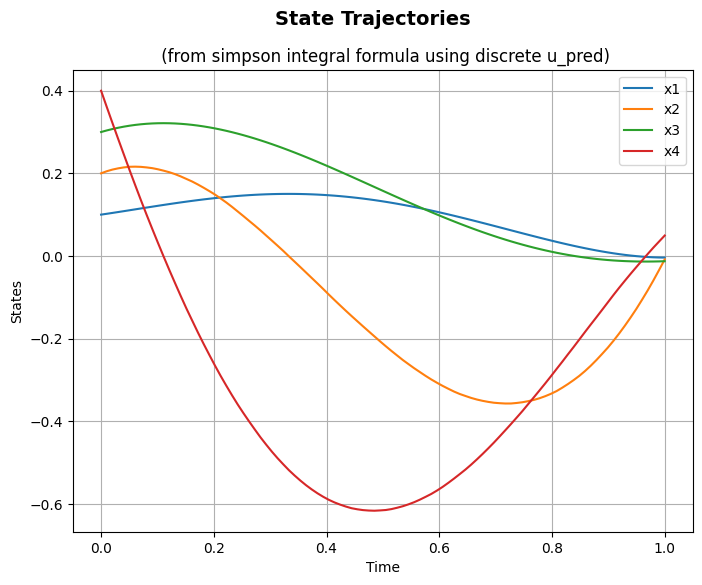

In [10]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.linalg import expm
from scipy.integrate import simpson # For numerical integration using Simpson's rule

n = A.shape[0] # State dimension
m = B.shape[1]

# Initialize the state trajectory array
x_trajectory_discrete_int = np.zeros((len(time_points), n))

# The initial state is x(0) = x0
x_trajectory_discrete_int[0, :] = x0

# Iterate through the time points to compute x(t) at each point
for i, t in enumerate(time_points):
    if i == 0:
        continue # Already set the initial state

    # Select the time points up to the current time t (inclusive) and the corresponding u_pred values
    time_points_subset = time_points[:i+1]
    u_pred_subset = u_pred[:, :i+1] # u_pred shape is (m, N)

    # Calculate the first part: exp(A*t) * x0
    exp_At = expm(A * t)
    x_part1 = exp_At @ x0

    # Calculate the integrand values at the discrete time points in the subset [0, t]
    # The integrand is F(s) = exp(A*(t-s)) @ B @ u(s)
    # F(s) is a vector of shape (n,)
    integrand_values = np.zeros((n, len(time_points_subset)))

    for k, s in enumerate(time_points_subset):
        exp_A_ts = expm(A * (t - s))
        u_s = u_pred_subset[:, k].reshape(-1, 1) # u at time s, reshaped to column vector
        integrand_values[:, k] = (exp_A_ts @ B @ u_s).flatten()

    # Numerically integrate the integrand values from 0 to t using Simpson's rule
    # Integrate each component of the vector integrand separately
    integral_result = np.zeros(n)
    for j in range(n): # Integrate for each state variable component
        # integrand_values[j, :] contains the values of the j-th component of the integrand at time_points_subset
        integral_result[j] = simpson(integrand_values[j, :], time_points_subset)

    # The state x(t) is the sum of the two parts
    x_trajectory_discrete_int[i, :] = x_part1 + integral_result

print("The solution of the system using discrete integration of the formula is:")
# Print the trajectory at the final time point as an example
print(f"State at t={time_points[-1]:.2f}: {x_trajectory_discrete_int[-1]}")


# Plotting the solution
z = time_points

# x_trajectory_discrete_int has shape (N, n), so I slice columns for each state
xt1 = x_trajectory_discrete_int[:, 0]
xt2 = x_trajectory_discrete_int[:, 1]
xt3 = x_trajectory_discrete_int[:, 2]
xt4 = x_trajectory_discrete_int[:, 3]


plt.figure(figsize=(8, 6))
plt.plot(z, xt1, label='x1')
plt.plot(z, xt2, label='x2')
plt.plot(z, xt3, label='x3')
plt.plot(z, xt4, label='x4')
plt.suptitle("State Trajectories",fontsize=14,fontweight='bold')
plt.title(" (from simpson integral formula using discrete u_pred)")
plt.xlabel("Time")
plt.ylabel("States")
plt.legend()
plt.grid(True)
plt.show()

##**1.7.2.Using Quadrature's Rule**

The solution of the system using quad_vec integration is:
State at t=1.00: [-0.00445454 -0.0084634  -0.01231771  0.05082908]


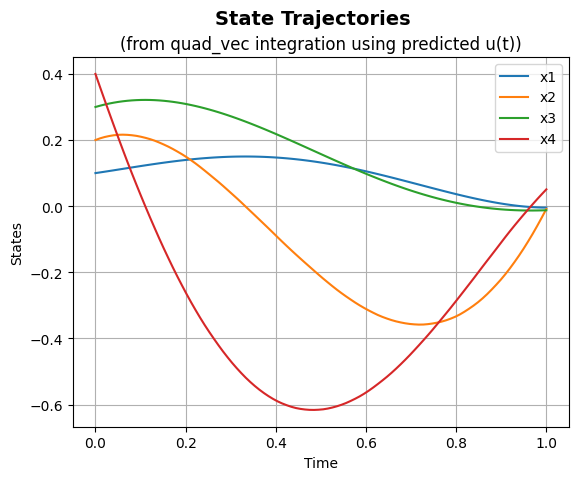

In [11]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.linalg import expm
from scipy.integrate import quad_vec # For numerical integration of vector functions

# Assuming A, B, T, time_points, x0, u_pred are already defined from previous cells
n = A.shape[0] # State dimension

# Initialize the state trajectory array
x_trajectory_quad_vec = np.zeros((len(time_points), n))

# The initial state is x(0) = x0
x_trajectory_quad_vec[0, :] = x0

# Iterate through the time points to compute x(t) at each point
for i, t in enumerate(time_points):
    if i == 0:
        continue # Already set the initial state

    # Calculate the first part: exp(A*t) * x0
    exp_At = expm(A * t)
    x_part1 = exp_At @ x0

    # Calculate the second part: integral from 0 to t of exp(A*(t-s)) * B * u(s) ds

    # Define the integrand function for quad_vec
    # The integrand should return a vector (or 1D array)
    # The integrand function signature for quad_vec is func(s, *args)
    # Here, the arguments needed are A, B, t, u_pred, time_points

    def integrand_vec_func(s, A, B, current_t, u_pred, time_points):
        # Find the index in time_points closest to s to get u(s)
        idx_s = (np.abs(time_points - s)).argmin()
        u_s = u_pred[:, idx_s].reshape(-1, 1) # Reshape to column vector

        # Calculate the vector integrand: exp(A*(t-s)) @ B @ u(s)
        exp_A_ts = expm(A * (current_t - s))
        integrand_value = exp_A_ts @ B @ u_s

        return integrand_value.flatten() # quad_vec expects a 1D array

    # Perform the integration from 0 to t using quad_vec
    # quad_vec returns the result as a 1D array and an error estimate
    integral_result_vec, _ = quad_vec(integrand_vec_func, 0, t, args=(A, B, t, u_pred, time_points))

    # The state x(t) is the sum of the two parts
    x_trajectory_quad_vec[i, :] = x_part1 + integral_result_vec

print("The solution of the system using quad_vec integration is:")
# Print the trajectory at the final time point as an example
print(f"State at t={time_points[-1]:.2f}: {x_trajectory_quad_vec[-1]}")

# Plotting the solution
z = time_points # Use the time points from the integration results

# x_trajectory_quad_vec has shape (N, n), so we slice columns for each state
xt1_vec = x_trajectory_quad_vec[:, 0]
xt2_vec = x_trajectory_quad_vec[:, 1]
xt3_vec = x_trajectory_quad_vec[:, 2]
xt4_vec = x_trajectory_quad_vec[:, 3]

plt.figure()
plt.plot(z, xt1_vec, label='x1')
plt.plot(z, xt2_vec, label='x2')
plt.plot(z, xt3_vec, label='x3')
plt.plot(z, xt4_vec, label='x4')
plt.suptitle("State Trajectories",fontsize=14,fontweight='bold')
plt.title("(from quad_vec integration using predicted u(t))")
plt.xlabel("Time")
plt.ylabel("States")
plt.legend()
plt.grid(True)
plt.show()

In [15]:
model.save('my_trained_model.keras')

print("Model saved as my_trained_model.keras")

Model saved as my_trained_model.keras


#**Mathematical and Computational Tools Used**

> State-space representation of dynamic systems

> Matrix exponentials and integral solutions

> Numerical integration using SciPy

> TensorFlow for building and training the neural network

> Matplotlib for visualizing state trajectories

#**Outcome**

**I developed a data-driven control model using neural networks.The model successfully learns a mapping from state transitions to control inputs.This bridges classical control theory with modern machine learning.**

#**Applications:**

1.**Autonomous Satellite Formation Flying:**

 >This type of  system can be used to control multiple satellites maintaining specific relative positions in orbit. By learning control inputs from trajectory pairs, it enables:
Smooth relative motion control,reduced fuel consumption and real-time decision-making during formation reconfiguration.

2.**Docking of Spacecraft**

>In missions like ISS resupply or debris removal, this type of  learned control system helps in:

>    (i) Predicting precise control inputs for trajectory corrections
    (ii) Performing soft and safe docking with non-cooperative targets
    (iii) Minimizing manual interventions in time-critical operations

3.**Low-Earth Orbit (LEO) Satellite Station-Keeping**

>Satellites in LEO are subject to atmospheric drag and need regular thrust corrections. this type of  MLP-based control framework can :
Predicts control commands based on deviations.Automates station-keeping maneuvers and Reduces computation load onboard via pre-trained models.

4.**Control Prototyping for Onboard AI Systems**
>In modern space missions, onboard intelligence is crucial. This  method:
  
>  Trains offline on ground simulators .Gets deployed onboard as a lightweight neural controller and Serves as a foundation for hybrid AI-control systems, combining physics and data.